In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Exploratory Data Analysis (EDA) — Intro Section

The dataset under study has already been preprocessed into **chunked texts** of 300–500 characters, 
resulting in a large corpus suitable for modeling. To handle the heavy dataset efficiently 
(~2.9 million records), we use **PySpark** for data extraction and summarization.

In this introductory stage of EDA, our goals are:
- Describe the **basic shape** of the dataset (total chunk records).
- Count the number of **unique authors** and **unique titles** in the corpus.
- Explore **genre distribution**, with a special focus on "Fantasy" records.
- Provide a few **interesting facts** about the corpus to set the stage for deeper visual analysis.

In [8]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


📊 Dataset Overview
Total chunked records: 2,930,069
Unique authors: 142
Unique titles: 3022


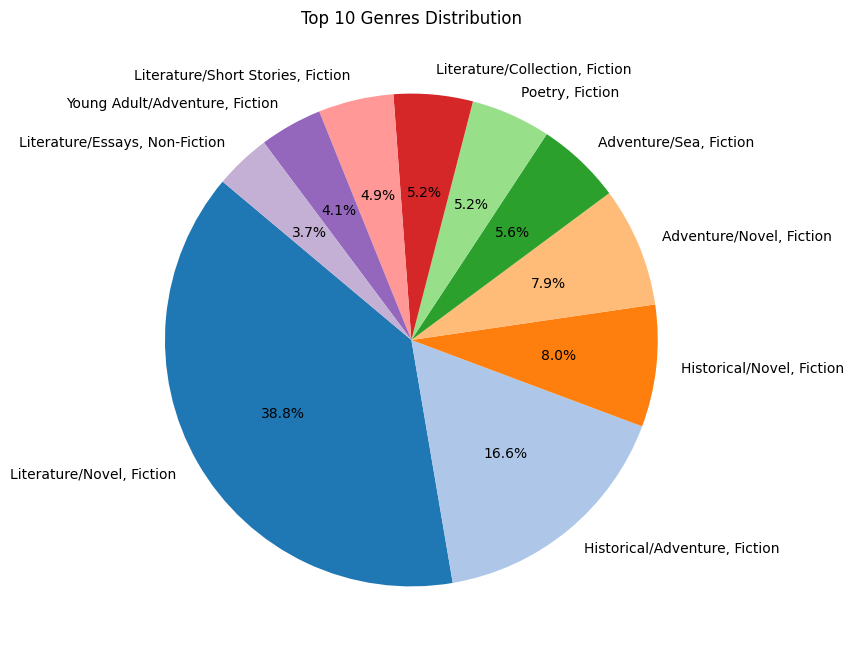

C:\Users\lab_services_student\AppData\Local\Temp\ipykernel_11008\1141602457.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="author", y="count", data=top_authors, palette="viridis")


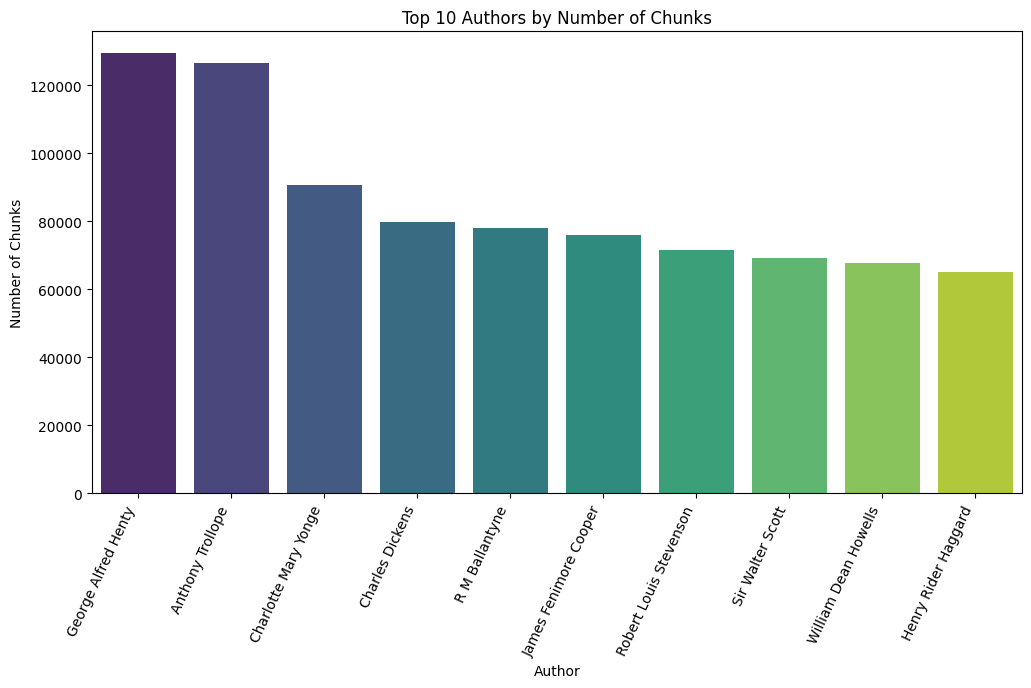


Total Authors: 142
Total Titles (unique books): 3022


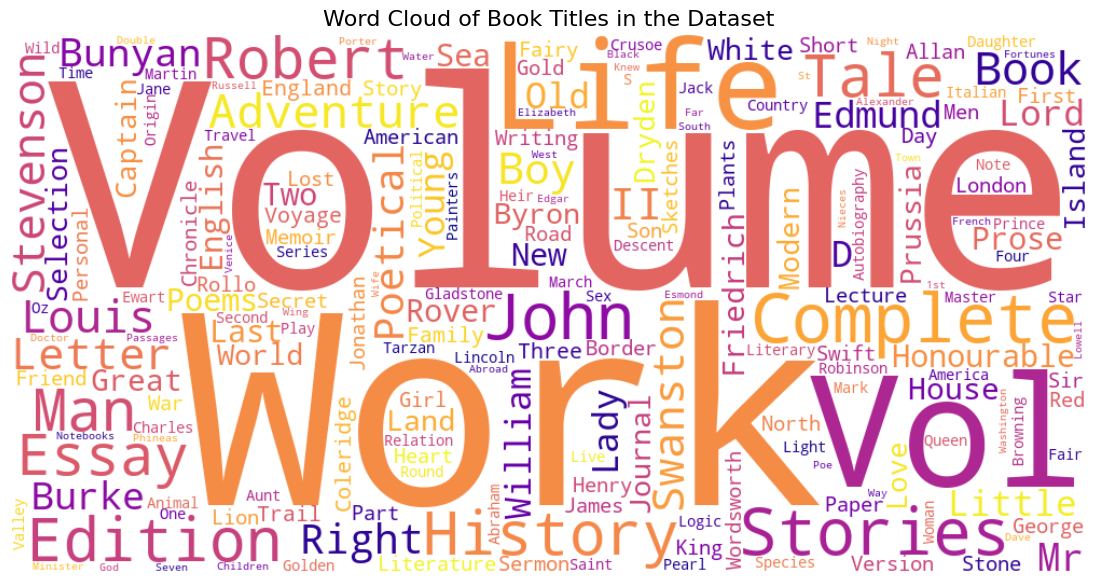

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# --- Start Spark session ---
spark = SparkSession.builder.appName("AuthorEDA").getOrCreate()

# --- Load dataset (~2.9M rows) ---
df = spark.read.csv("dataset_splits/full_chunked.csv", header=True, inferSchema=True)

# -----------------
#  BASIC STATS
# -----------------
total_records = df.count()
unique_authors = df.select("author").distinct().count()
unique_titles = df.select("title").distinct().count()

print(" Dataset Overview")
print(f"Total chunked records: {total_records:,}")
print(f"Unique authors: {unique_authors}")
print(f"Unique titles: {unique_titles}")

# -----------------
# 🎭 GENRE DISTRIBUTION
# -----------------
genre_counts = df.groupBy("genre").count().orderBy(col("count").desc())
genre_counts_pd = genre_counts.toPandas()   # convert to Pandas for plotting

# Pie chart of top 10 genres
top_genres = genre_counts_pd.head(10)
plt.figure(figsize=(8, 8))
plt.pie(top_genres['count'], labels=top_genres['genre'],
        autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title("Top 10 Genres Distribution")
plt.show()

# -----------------
# 👤 TOP 10 AUTHORS
# -----------------
author_counts = df.groupBy("author").count().orderBy(col("count").desc())
author_counts_pd = author_counts.toPandas()

top_authors = author_counts_pd.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="author", y="count", data=top_authors, palette="viridis")
plt.xticks(rotation=65, ha="right")
plt.title("Top 10 Authors by Number of Chunks")
plt.ylabel("Number of Chunks")
plt.xlabel("Author")
plt.show()

# -----------------
# 📚 HOW MANY AUTHORS / TITLES
# -----------------
print(f"\nTotal Authors: {unique_authors}")
print(f"Total Titles (unique books): {unique_titles}")

# -----------------
# 🌌 WORD CLOUD for TITLES
# -----------------
# Collect all titles (could be 3k unique, repeated across ~2.9M chunks)
titles_pd = df.select("title").toPandas()

# Join all titles into one big string
titles_combined = " ".join(titles_pd['title'].dropna().tolist())

# Generate a word cloud where frequent titles (or words IN titles) are bigger
wordcloud_titles = WordCloud(width=1000, height=500,
                             background_color="white",
                             colormap="plasma",
                             collocations=False).generate(titles_combined)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud_titles, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Book Titles in the Dataset", fontsize=16)
plt.show()

### Step 2 — Preprocessing for LSTM

For our LSTM author classification model, we adopt a **character-level** preprocessing strategy.

1. **Build Character Vocabulary**  
   Extract all unique characters in the training set and map them to integer IDs.  
   (e.g., {'a': 1, 'b': 2, ..., ' ': 27, '!': 28, ...}). Padding is reserved as 0.

2. **Text to Sequences**  
   Convert each text chunk into a sequence of character IDs.

3. **Sequence Padding**  
   Pad or truncate each sequence to a uniform fixed length: **2000 characters**.  
   This ensures consistent tensor inputs for the LSTM.

4. **Author Labels Encoding**  
   Encode string author names into integer labels (0…N-1).

This preprocessing prepares the data in a format suitable for feeding into an LSTM:  
`X_train, X_val, X_test` → padded numeric sequences of chars,  
`y_train, y_val, y_test` → integer author labels.  

In [ ]:
%pip install tensorflow

In [11]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# ---------------------------
# Load Data
# ---------------------------
train_df = pd.read_csv("dataset_splits/train.csv")
val_df   = pd.read_csv("dataset_splits/val.csv")
test_df  = pd.read_csv("dataset_splits/test.csv")

print("✅ Data loaded")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ---------------------------
# Build Char Vocabulary
# ---------------------------
all_text = "".join(train_df['chunk_text'].astype(str).tolist())
chars = sorted(list(set(all_text)))
char_to_int = {c: i+1 for i, c in enumerate(chars)}  # start idx=1, keep 0 for padding
int_to_char = {i: c for c, i in char_to_int.items()}

print(f"✅ Built vocab of {len(char_to_int)} unique characters")

# ---------------------------
# Encode Text Function
# ---------------------------
def encode_text(text, mapping):
    return [mapping.get(c, 0) for c in text]  # unknown -> 0

train_seqs = [encode_text(t, char_to_int) for t in train_df['chunk_text'].astype(str)]
val_seqs   = [encode_text(t, char_to_int) for t in val_df['chunk_text'].astype(str)]
test_seqs  = [encode_text(t, char_to_int) for t in test_df['chunk_text'].astype(str)]

# ---------------------------
# Pad Sequences
# ---------------------------
MAX_LEN = 2000  # fixed size for input
X_train = pad_sequences(train_seqs, maxlen=MAX_LEN, padding='post', truncating='post')
X_val   = pad_sequences(val_seqs,   maxlen=MAX_LEN, padding='post', truncating='post')
X_test  = pad_sequences(test_seqs,  maxlen=MAX_LEN, padding='post', truncating='post')

print(f"✅ Shapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

# ---------------------------
# Encode Labels (Authors)
# ---------------------------
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['author'])
y_val   = label_encoder.transform(val_df['author'])
y_test  = label_encoder.transform(test_df['author'])

print(f"✅ Encoded {len(label_encoder.classes_)} authors")

# ---------------------------
# Output Ready
# ---------------------------
print("🎯 Preprocessing complete! Data ready for LSTM training")
print("   - X_train, X_val, X_test: Padded int sequences")
print("   - y_train, y_val, y_test: Encoded author labels")
print("💡 char_to_int & int_to_char dictionaries available for encoding/decoding")

ModuleNotFoundError: No module named 'tensorflow'